# CIFAR-10 Double Descent Experiments

**GRA4157 Big Data - Final Project**

Jakob Sverre Alexandersen

This notebook runs width-sweep double descent experiments on CIFAR-10, training models of varying width to observe model-wise double descent.


In [1]:
# global seed for reproducibility
SEED = 42

# experiment configuration
CONFIG = {
    'seed': SEED,
    'width_sweep': {
        'num_epochs': 200,
        'learning_rate': 0.001,
        'label_noise': 0.15,        # add noise to make DD peak more visible
        'train_subset_size': 10000,  # smaller subset to hit interpolation faster
        'results_dir': 'results/width_sweep'
    }
}

print(f"configuration loaded with seed: {SEED}")
print(f"width-sweep: {CONFIG['width_sweep']['num_epochs']} epochs, {CONFIG['width_sweep']['label_noise']*100:.0f}% label noise")


configuration loaded with seed: 42
width-sweep: 200 epochs, 15% label noise


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.manifold import TSNE

# import experiment functions
from cifar10_experiments import (
    load_cifar10,
    get_class_names,
    run_width_sweep_experiment,
    create_results_summary_table
)

# set random seeds for all libraries
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    print("using MPS")
else:
    print("using CPU")


Using device: cuda
GPU: NVIDIA GeForce RTX 5090
CUDA version: 12.8
available GPU memory: 33.7 GB


## Dataset Exploration

Before running double descent experiments, we first explore the CIFAR-10 dataset to understand its size, class balance, and some example images.


In [4]:
print("="*80)
print("loading cifar-10 dataset")
print("="*80)
print(f"start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

X_train, X_val, X_test, y_train, y_val, y_test = load_cifar10(seed=SEED)
class_names = get_class_names()

print(f"\nclass names: {class_names}")


loading cifar-10 dataset
start time: 2025-12-04 13:37:48


train set: 35000 samples
validation set: 15000 samples
test set: 10000 samples
classes: 10

class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# basic dataset statistics and image tensors

num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_features = X_train.shape[1]

print(f"train set: {num_train} samples")
print(f"validation set: {num_val} samples")
print(f"test set: {num_test} samples")
print(f"input dimensionality: {num_features} = 3 * 32 * 32")

# reshape flattened vectors back into image tensors for visualization: (N, C, H, W)
X_train_img = X_train.reshape(-1, 3, 32, 32)
X_val_img = X_val.reshape(-1, 3, 32, 32)
X_test_img = X_test.reshape(-1, 3, 32, 32)

print(f"train images tensor shape: {X_train_img.shape}")
print(f"validation images tensor shape: {X_val_img.shape}")
print(f"test images tensor shape: {X_test_img.shape}")

# per-channel pixel statistics in the normalized space
channel_names = ['R', 'G', 'B']
train_channel_means_norm = X_train_img.mean(axis=(0, 2, 3))
train_channel_stds_norm = X_train_img.std(axis=(0, 2, 3))

print("\nper-channel statistics (normalized space, train split):")
for ch, m, s in zip(channel_names, train_channel_means_norm, train_channel_stds_norm):
    print(f"  {ch}: mean={m:.3f}, std={s:.3f}")

print(f"\nnormalized pixel range (train): min={X_train_img.min():.2f}, max={X_train_img.max():.2f}")



train set: 35000 samples
validation set: 15000 samples
test set: 10000 samples
input dimensionality: 3072 = 3 * 32 * 32
train images tensor shape: (35000, 3, 32, 32)
validation images tensor shape: (15000, 3, 32, 32)
test images tensor shape: (10000, 3, 32, 32)

per-channel statistics (normalized space, train split):
  R: mean=0.001, std=0.999
  G: mean=0.001, std=1.000
  B: mean=0.001, std=1.000

normalized pixel range (train): min=-1.99, max=2.13


## First image creates Figure 1

class counts (train / val / test / total):
 0 - airplane  :   3500 /   1500 /   1000 /   6000
 1 - automobile:   3500 /   1500 /   1000 /   6000
 2 - bird      :   3500 /   1500 /   1000 /   6000
 3 - cat       :   3500 /   1500 /   1000 /   6000
 4 - deer      :   3500 /   1500 /   1000 /   6000
 5 - dog       :   3500 /   1500 /   1000 /   6000
 6 - frog      :   3500 /   1500 /   1000 /   6000
 7 - horse     :   3500 /   1500 /   1000 /   6000
 8 - ship      :   3500 /   1500 /   1000 /   6000
 9 - truck     :   3500 /   1500 /   1000 /   6000


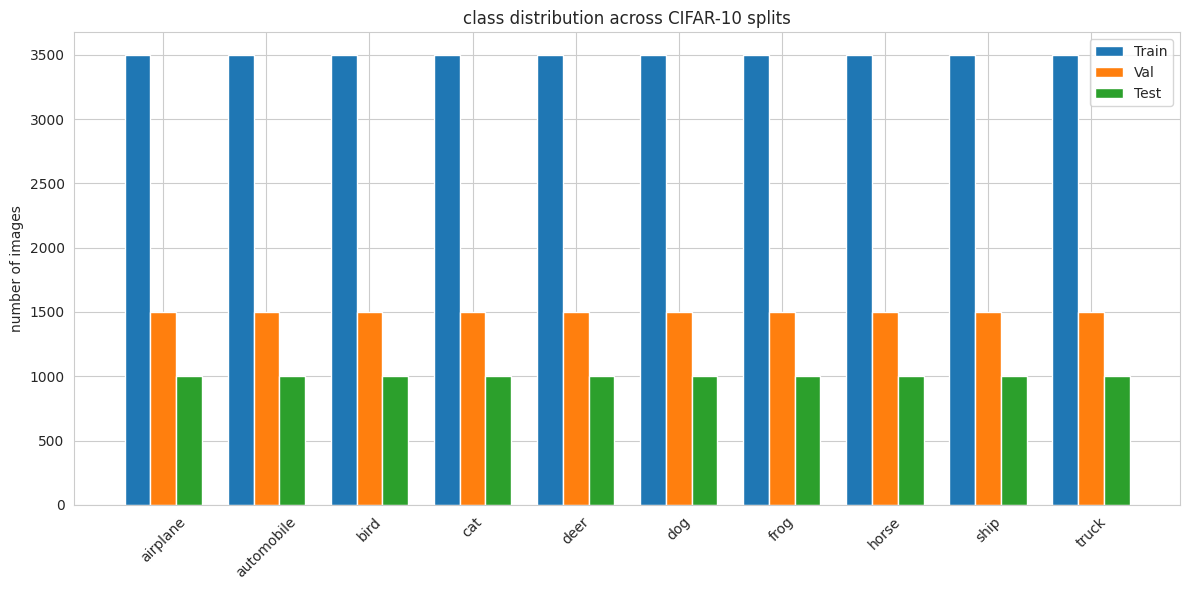

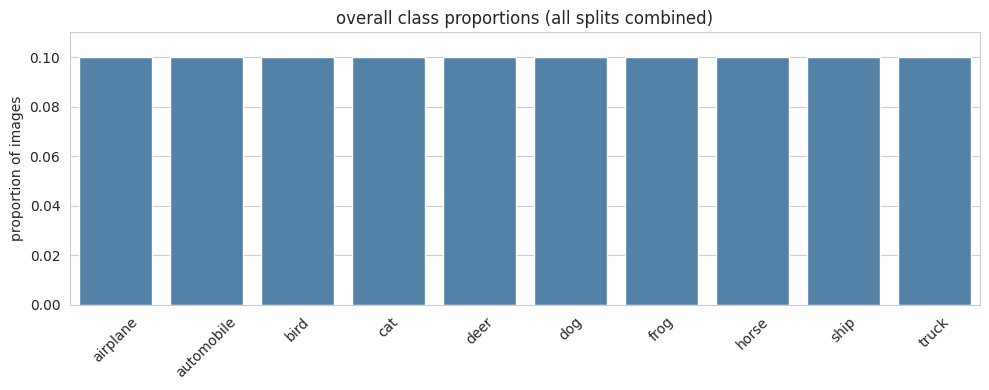

In [6]:
# class balance across train / validation / test splits

num_classes = len(class_names)

train_counts = np.bincount(y_train, minlength=num_classes)
val_counts = np.bincount(y_val, minlength=num_classes)
test_counts = np.bincount(y_test, minlength=num_classes)

total_counts = train_counts + val_counts + test_counts

print("class counts (train / val / test / total):")
for idx, name in enumerate(class_names):
    print(
        f"{idx:2d} - {name:10s}: "
        f"{train_counts[idx]:6d} / {val_counts[idx]:6d} / {test_counts[idx]:6d} / {total_counts[idx]:6d}"
    )

# plot class distribution for each split
indices = np.arange(num_classes)
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(indices - width, train_counts, width=width, label="Train")
plt.bar(indices,         val_counts,   width=width, label="Val")
plt.bar(indices + width, test_counts,  width=width, label="Test")
plt.xticks(indices, class_names, rotation=45)
plt.ylabel("number of images")
plt.title("class distribution across CIFAR-10 splits")
plt.legend()
plt.tight_layout()
plt.show()

# plot overall class distribution (normalized proportions)
overall_probs = total_counts / total_counts.sum()

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=overall_probs, color="steelblue")
plt.ylabel("proportion of images")
plt.title("overall class proportions (all splits combined)")
plt.xticks(rotation=45)
plt.ylim(0, overall_probs.max() * 1.1)
plt.tight_layout()
plt.show()



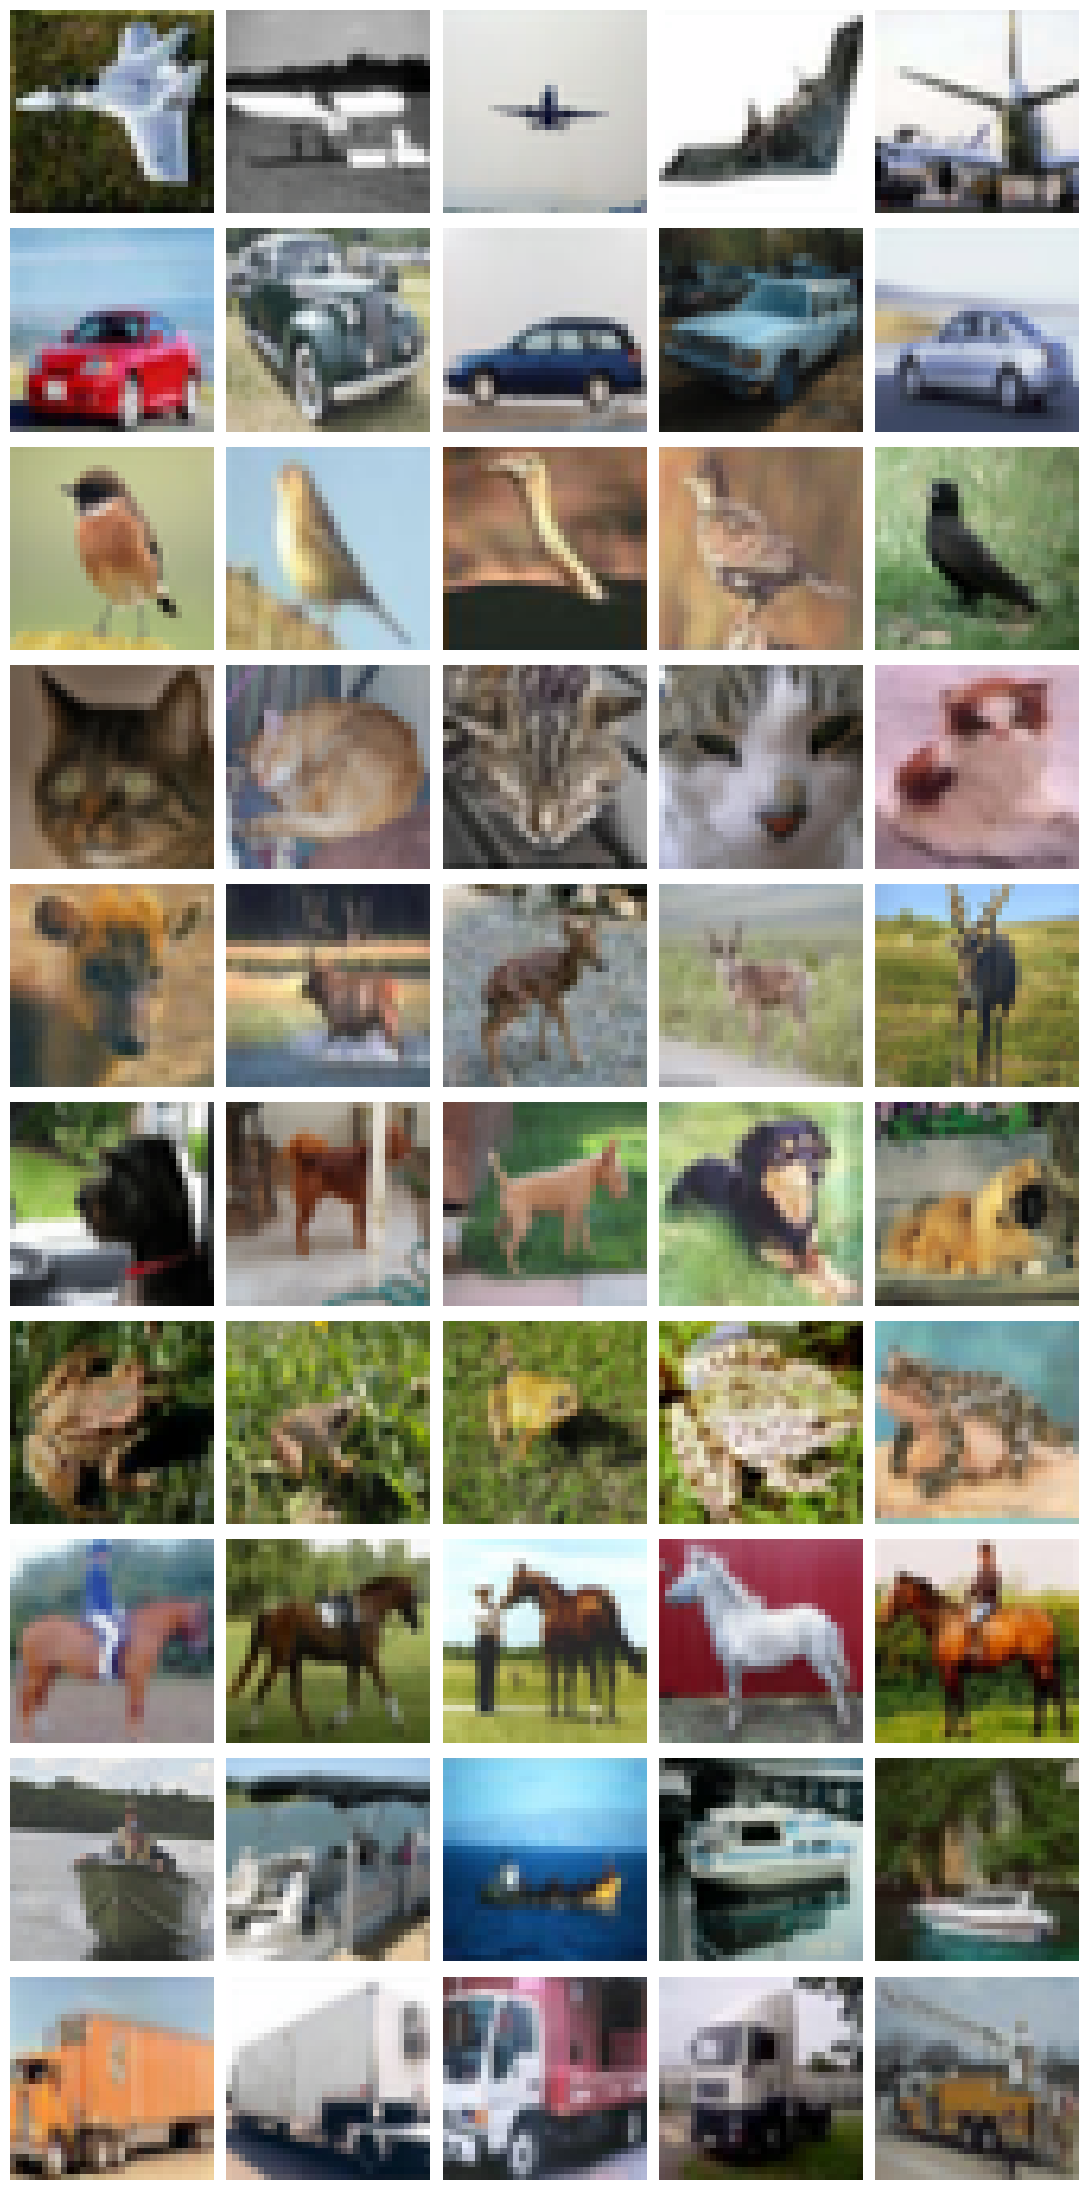

In [7]:
# visualize example images from the training set

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])


def unnormalize(img):
    """Convert a normalized image tensor (3, 32, 32) back to [0, 1] RGB image for plotting."""
    img = img * std[:, None, None] + mean[:, None, None]
    img = np.clip(img, 0.0, 1.0)
    return np.transpose(img, (1, 2, 0))  # (H, W, C) for matplotlib


num_classes = len(class_names)
samples_per_class = 5

fig, axes = plt.subplots(
    num_classes,
    samples_per_class,
    figsize=(2.2 * samples_per_class, 2.2 * num_classes)
)

for class_idx, class_name in enumerate(class_names):
    class_indices = np.where(y_train == class_idx)[0]
    # in the unlikely event a class has fewer samples than requested, allow replacement
    replace = len(class_indices) < samples_per_class
    selected_indices = np.random.choice(
        class_indices, size=samples_per_class, replace=replace
    )

    for j, idx in enumerate(selected_indices):
        ax = axes[class_idx, j] if num_classes > 1 else axes[j]
        img = unnormalize(X_train_img[idx])
        ax.imshow(img)
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(
                class_name,
                rotation=0,
                ha="right",
                va="center",
                fontsize=10,
            )

plt.tight_layout()
plt.show()



## Full training set tsne (figure 2)

running TSNE on 35000 training samples (out of 35000) ...


TSNE completed.


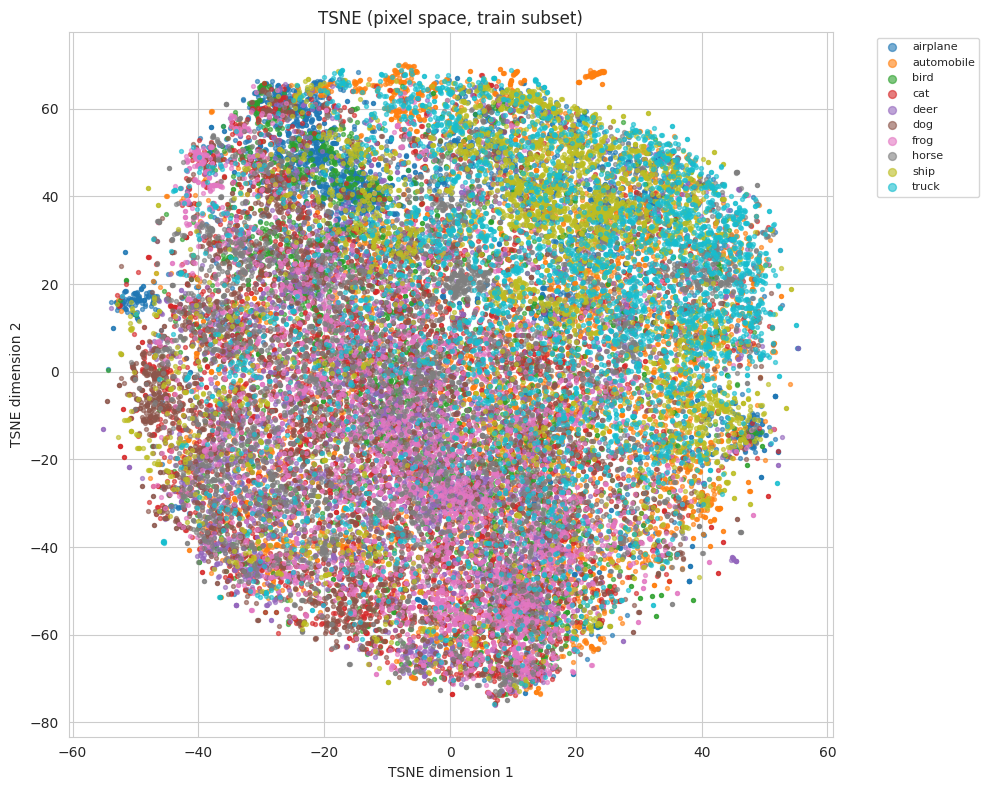

In [8]:
max_samples = 35_000
num_train = X_train.shape[0]

subset_size = min(max_samples, num_train)
subset_indices = np.random.choice(num_train, size=subset_size, replace=False)

X_subset = X_train[subset_indices]
y_subset = y_train[subset_indices]

print(f"running TSNE on {subset_size} training samples (out of {num_train}) ...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=SEED,
)
X_embedded = tsne.fit_transform(X_subset)

print("TSNE completed.")

# plot the 2D embedding, colored by class
plt.figure(figsize=(10, 8))

palette = sns.color_palette("tab10", n_colors=len(class_names))
for class_idx, class_name in enumerate(class_names):
    mask = y_subset == class_idx
    plt.scatter(
        X_embedded[mask, 0],
        X_embedded[mask, 1],
        s=8,
        color=palette[class_idx],
        alpha=0.6,
        label=class_name,
    )

plt.title("TSNE (pixel space, train subset)")
plt.xlabel("TSNE dimension 1")
plt.ylabel("TSNE dimension 2")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



## Width-Sweep Double Descent Experiment

Train models of varying width to observe model-wise double descent.
Uses 15% label noise and 10k training subset to make the interpolation threshold peak more visible.


In [9]:
print("width-sweep double descent experiment")

width_sweep_results = run_width_sweep_experiment(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    num_epochs=CONFIG['width_sweep']['num_epochs'],
    learning_rate=CONFIG['width_sweep']['learning_rate'],
    label_noise=CONFIG['width_sweep']['label_noise'],
    train_subset_size=CONFIG['width_sweep']['train_subset_size'],
    results_dir=CONFIG['width_sweep']['results_dir'],
    seed=SEED
)

# save results summary
create_results_summary_table(width_sweep_results, save_path='report/figures/width_sweep_results.txt')

# find best width and plot confusion matrix
best_width = max(width_sweep_results.keys(), key=lambda k: width_sweep_results[k]['test_f1'])


print(f"\nbest width: {best_width} with F1 = {width_sweep_results[best_width]['test_f1']:.4f}")


width-sweep double descent experiment
WIDTH-SWEEP DOUBLE DESCENT EXPERIMENT
training for 200 epochs per model
using subset of 10000 training samples
added 15% label noise (1500 labels)

[1/23] training width multiplier = 1
  skipping - already trained for 200 epochs (>= 200)

[2/23] training width multiplier = 2
  skipping - already trained for 200 epochs (>= 200)

[3/23] training width multiplier = 3
  skipping - already trained for 200 epochs (>= 200)

[4/23] training width multiplier = 4
  skipping - already trained for 200 epochs (>= 200)

[5/23] training width multiplier = 5
  skipping - already trained for 200 epochs (>= 200)

[6/23] training width multiplier = 6
  skipping - already trained for 200 epochs (>= 200)

[7/23] training width multiplier = 7
  skipping - already trained for 200 epochs (>= 200)

[8/23] training width multiplier = 8
  skipping - already trained for 200 epochs (>= 200)

[9/23] training width multiplier = 9
  skipping - already trained for 200 epochs (>= 2

# Width-sweep double descent results (figure 3)

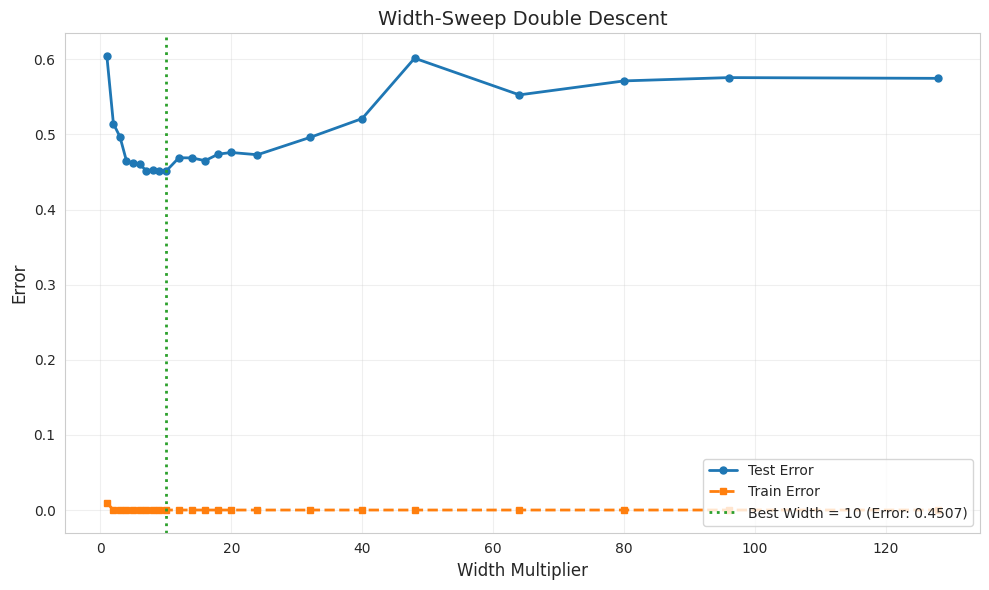

In [10]:
import pickle
import matplotlib.pyplot as plt

# load results from width_sweep folder
with open('results/width_sweep/all_results.pkl', 'rb') as f:
    width_sweep_results = pickle.load(f)

# extract data from results
widths = []
train_errors = []
test_errors = []

for width, result in sorted(width_sweep_results.items()):
    widths.append(width)
    train_errors.append(result["train_error"])
    test_errors.append(result["test_error"])

# find best width (lowest test error)
best_idx = test_errors.index(min(test_errors))
best_width = widths[best_idx]
best_error = test_errors[best_idx]

# simple plot with white background
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(widths, test_errors, '-o', linewidth=2, markersize=5, color='tab:blue', label='Test Error')
ax.plot(widths, train_errors, '--s', linewidth=2, markersize=4, color='tab:orange', label='Train Error')

# add vertical line at best width
ax.axvline(x=best_width, color='tab:green', linestyle=':', linewidth=2, 
           label=f'Best Width = {best_width} (Error: {best_error:.4f})')

ax.set_xlabel('Width Multiplier', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Width-Sweep Double Descent', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()